# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f9d185eba00>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f9d17bba950>])

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [9]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
depoly = False

In [11]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [12]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

## 4. Invocation (prediction)

In [13]:
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f9cfc596b60>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 92.4 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [24]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index


### OpenSearch Client 생성

In [25]:
from utils.opensearch import opensearch_utils

In [26]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [27]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

감염병의 정의와 종류
감염병 전파 경로와 예방법

===== RAG-Fusion Queries =====
['감염병의 종류와 경로는?', '감염병의 정의와 종류', '감염병 전파 경로와 예방법']
감염병의 종류
감염병 전파 경로
바이러스와 세균 감염병의 차이

### Retriever 정의

In [28]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=True, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True,
)

### QA chain 정의

In [29]:
system_prompt = prompt_repo.get_system_prompt()

In [30]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

===== ParentDocument =====
filter: [{'bool': {'should': [{'term': {'metadata.family_tree': 'child'}}, {'term': {'metadata.family_tree': 'parent_table'}}, {'term': {'metadata.family_tree': 'parent_image'}}]}}]
# child_docs: 5
# parent docs: 5
# duplicates: 0
##############################
async_mode
##############################
True
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
True
##############################
complex_document
##############################
True
##############################
similar_docs_semantic
##############################

Score: 0.01639344262295

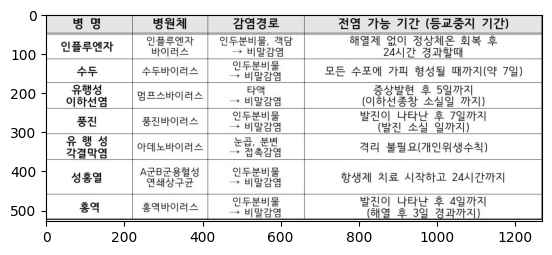

이 표는 여러 감염성 질환들에 대한 정보를 제공합니다. 각 질환의 병원체, 감염경로, 전염 가능 기간, 유행 여부 등에 대한 내용이 포함되어 있습니다. 인플루엔자, 수두, 유행성
이하선염, 풍진 등의 바이러스성 질환과 유행성 각결막염, 성홍열, 홍역 등의 세균성 질환에 대한 정보가 수록되어 있습니다.
metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'detection_class_prob': 0.9286118149757385,
'coordinates': {'points': [[195.04476928710938, 417.447509765625], [195.04476928710938,
945.0703125], [1465.962890625, 945.0703125], [1465.962890625, 417.447509765625]], 'system':
'PixelSpace', 'layout_width': 1653, 'layout_height': 2337}, 'last_modified': '2024-04-04T01:39:24',
'text_as_html': "<table><thead><th>go| : |</th><th>리 = 해</th><th>때 푸</th><th>= N — — =l o 똥 느 니 S N
== e 벽 &amp;</th></thead><tr><td>' 3 따 삐 i</td><td>언쓰 ] 따 므 | 736 = oI</td><td>뷰 죄 80 통 시 브답 e el
od</td><td>|19| Sk I | |ou i 꼭 15079 220 | | =&lt; ㅇ eV 122576 sl |</td></tr><tr><td>바 바 |
&lt;+</td><td>긴 오 꼬 바 아</td><td>비 4시 과 16 띠 나코</td><td>7 일 ) o X 돈 s 0 0 0 =3 |7 = 벗 벗
비</td></tr><tr><td>99 |20 700 인 야이 )</td><td>07696 | 움 개토 꼬 &lt;| 

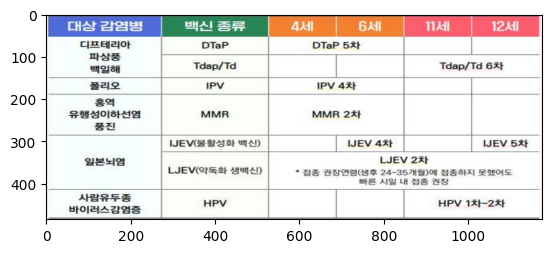

이 표는 다양한 감염병과 예방 접종 일정을 보여줍니다. 대상 감염병에는 디프테리아, 파상풍, 백일해, 폴리오, 홍역, 유행성이하선염 등이 포함되어 있습니다. 접종 시기는 4개월,
6개월, 11개월, 12개월 등으로 나뉘어 있습니다. 백신의 종류와 접종 차수에 대한 자세한 정보가 제공되고 있습니다. 이를 통해 적절한 예방접종 계획을 세울 수 있습니다.
metadata:
 {'img_path': './fig/figure-28-56.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '81b1daf6-e43c-47c2-806f-27956b3f4c90', 'origin_image': ''}

-----------------------------------------------
3. Category: CompositeElement, Chunk: 634 Characters
-----------------------------------------------
코로나 백신 접종 ▸접종 당일에 대해 출석인정결석처리 ▸이상반응 발생 시 2일까지 출석인정 처리 가능 ▸접종 후 3일부터 질병결석 처리 결석계와 담임교사확인서+증빙서류 (예 방 접
종 확 인 서 ,의 사 소 견 서 등 ) 19 코로나19 학교장 허가교외 체험학습 ▸확진(양성) 시에는 격리 권고 기간 5일 출석 인정 ▸음성 시에는 당일 1일 출석 인정 당 '
습 + 가 정 습 통 ▸기존 교외체험학습+가정학습 통합하여 연간 20일 이내(해당 학년도) ▸국외 신청시 비행기나 배편 e-ticket(왕복) 사본 첨부(증빙자료) ▸국가 감염병
심각 단계에서만 가정학습 포함 (감염병 위기경보단계확인 : https://naver.me/55yVhEUd) ▸4시간 미만은 반일 운영(단, 반일은 당일 수업 참여한 경우에 한하여
허가) | | ㅣ , 결석계와 담임교사확인서+증빙서류 (의 사 소 견 서 ,검 사

In [31]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
#query = "자산총계 금액 알려줘"
#query = "대출채권 금액은?"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"

query = "재난 발생 시 대처사항은?"
query = "학교폭력 처리 과정은?"
query = "감염병의 종류와 경로는?"
#query = "홍역에 대한 백신 이름은?"
#query = "MMR 2차의 예방접종 시기는?"
#query = "교육목표는?"
#query = "만기상환금액 알려줘"

response, contexts = qa.invoke(
    query = query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [32]:
opensearch_hybrid_retriever.update_search_params(
    k=5,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger = "None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [33]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

##
query = "학기 초에 어린이 납치 예방 방법은?" # semantic o, lexical x
query = "차 흡연 옷. 벽면에 붙은 연기로 인한 피해?" # semantic o, lexical x
query = "교육목표는?"
#query = "수익률 그래프 설명해줘"
query = "감염병의 종류와 경로는?"
#query = "중지된 경우 이체"


In [34]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

이 표에는 여러 감염병의 종류와 감염 경로가 나와 있습니다. 

인플루엔자는 인플루엔자 바이러스에 의해 발생하며 인두분비물과 객담을 통해 비말감염됩니다. 

수두는 수두바이러스에 의한 질병으로 인두분비물을 통해 비말감염됩니다.  

유행성 이하선염은 멈프스바이러스 감염에 의해 발생하며 타액을 매개로 비말감염됩니다.

풍진은 풍진바이러스 감염으로 인두분비물을 통해 비말감염됩니다. 

유행성 각결막염은 아데노바이러스에 의해 발생하며 눈곱과 분변을 통해 접촉감염됩니다.

성홍열은 A군B군용혈성 연쇄상구균에 의한 질병으로 인두분비물을 통해 비말감염됩니다. 

홍역은 홍역바이러스 감염에 의해 발생하며 인두분비물로 비말감염됩니다.

##################################
query:  감염병의 종류와 경로는?
##################################


### Answer ###
이 표에는 여러 감염병의 종류와 감염 경로가 나와 있습니다.

인플루엔자는 인플루엔자 바이러스에 의해 발생하며 인두분비물과 객담을 통해 비말감염됩니다.

수두는 수두바이러스에 의한 질병으로 인두분비물을 통해 비말감염됩니다.

유행성 이하선염은 멈프스바이러스 감염에 의해 발생하며 타액을 매개로 비말감염됩니다.

풍진은 풍진바이러스 감염으로 인두분비물을 통해 비말감염됩니다.

유행성 각결막염은 아데노바이러스에 의해 발생하며 눈곱과 분변을 통해 접촉감염됩니다.

성홍열은 A군B군용혈성 연쇄상구균에 의한 질병으로 인두분비물을 통해 비말감염됩니다.

홍역은 홍역바이러스 감염에 의해 발생하며 인두분비물로 비말감염됩니다.


### Contexts ###

-----------------------------------------------
1. Category: Table, Chunk: 168 Characters
-----------------------------------------------


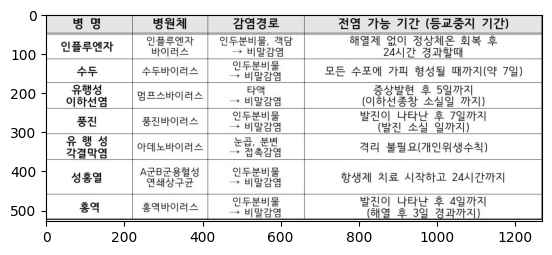

이 표는 여러 감염성 질환들에 대한 정보를 제공합니다. 각 질환의 병원체, 감염경로, 전염 가능 기간, 유행 여부 등에 대한 내용이 포함되어 있습니다. 인플루엔자, 수두, 유행성
이하선염, 풍진 등의 바이러스성 질환과 유행성 각결막염, 성홍열, 홍역 등의 세균성 질환에 대한 정보가 수록되어 있습니다.
metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'detection_class_prob': 0.9286118149757385,
'coordinates': {'points': [[195.04476928710938, 417.447509765625], [195.04476928710938,
945.0703125], [1465.962890625, 945.0703125], [1465.962890625, 417.447509765625]], 'system':
'PixelSpace', 'layout_width': 1653, 'layout_height': 2337}, 'last_modified': '2024-04-04T01:39:24',
'text_as_html': "<table><thead><th>go| : |</th><th>리 = 해</th><th>때 푸</th><th>= N — — =l o 똥 느 니 S N
== e 벽 &amp;</th></thead><tr><td>' 3 따 삐 i</td><td>언쓰 ] 따 므 | 736 = oI</td><td>뷰 죄 80 통 시 브답 e el
od</td><td>|19| Sk I | |ou i 꼭 15079 220 | | =&lt; ㅇ eV 122576 sl |</td></tr><tr><td>바 바 |
&lt;+</td><td>긴 오 꼬 바 아</td><td>비 4시 과 16 띠 나코</td><td>7 일 ) o X 돈 s 0 0 0 =3 |7 = 벗 벗
비</td></tr><tr><td>99 |20 700 인 야이 )</td><td>07696 | 움 개토 꼬 &lt;| 

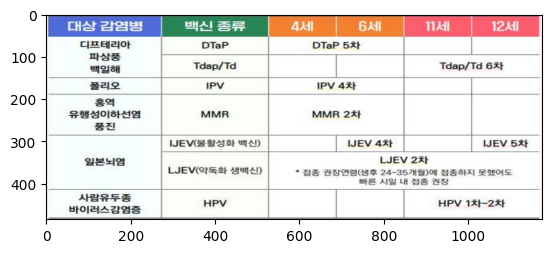

이 표는 다양한 감염병과 예방 접종 일정을 보여줍니다. 대상 감염병에는 디프테리아, 파상풍, 백일해, 폴리오, 홍역, 유행성이하선염 등이 포함되어 있습니다. 접종 시기는 4개월,
6개월, 11개월, 12개월 등으로 나뉘어 있습니다. 백신의 종류와 접종 차수에 대한 자세한 정보가 제공되고 있습니다. 이를 통해 적절한 예방접종 계획을 세울 수 있습니다.
metadata:
 {'img_path': './fig/figure-28-56.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '81b1daf6-e43c-47c2-806f-27956b3f4c90', 'origin_image': ''}

-----------------------------------------------
3. Category: CompositeElement, Chunk: 634 Characters
-----------------------------------------------
코로나 백신 접종 ▸접종 당일에 대해 출석인정결석처리 ▸이상반응 발생 시 2일까지 출석인정 처리 가능 ▸접종 후 3일부터 질병결석 처리 결석계와 담임교사확인서+증빙서류 (예 방 접
종 확 인 서 ,의 사 소 견 서 등 ) 19 코로나19 학교장 허가교외 체험학습 ▸확진(양성) 시에는 격리 권고 기간 5일 출석 인정 ▸음성 시에는 당일 1일 출석 인정 당 '
습 + 가 정 습 통 ▸기존 교외체험학습+가정학습 통합하여 연간 20일 이내(해당 학년도) ▸국외 신청시 비행기나 배편 e-ticket(왕복) 사본 첨부(증빙자료) ▸국가 감염병
심각 단계에서만 가정학습 포함 (감염병 위기경보단계확인 : https://naver.me/55yVhEUd) ▸4시간 미만은 반일 운영(단, 반일은 당일 수업 참여한 경우에 한하여
허가) | | ㅣ , 결석계와 담임교사확인서+증빙서류 (의 사 소 견 서 ,검 사

In [35]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)